# Feature Selection Codealong

In this notebook we will try 3 methods of feature selection:
* Filtering by correlation
* Selecting via Permutation Importance and SelectFromModel
* Applying SequentialFeatureSelector to test many models and find the best combination of features.

The data is the engineered data we created in the last lecture.  However, instead of PCA, we will try some feature selection methods.  

Once again we will bin the target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from sklearn import set_config
set_config(transform_output='pandas')

import joblib


In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [3]:
loaded = joblib.load('../Lecture 1/Data/engineered_student_data.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'columntransformer'])

In [4]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']
preprocessor = loaded['columntransformer']

X_train.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Semester,school/subject
15,1,17,U,1,T,3,3,other,other,reputation,...,0,4,3,4,1,4,4,1.609438,G1,GP mat
48,1,19,U,1,T,2,1,other,other,reputation,...,0,5,3,4,1,4,4,2.397895,G2,GP por
259,1,18,U,0,T,1,1,other,services,home,...,1,3,3,2,1,2,3,1.098612,G2,MS por
28,0,15,U,0,T,4,2,health,other,other,...,0,4,3,3,1,1,5,0.000000,G1,GP por
41,0,17,U,1,T,3,2,other,other,course,...,0,5,3,4,1,3,3,1.098612,G1,GP por


# Process the Data

In [5]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.shape

(2349, 51)

# Base Model

We will create a base model on all data to compare.

In [6]:
## Create and fit the initial model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_proc, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



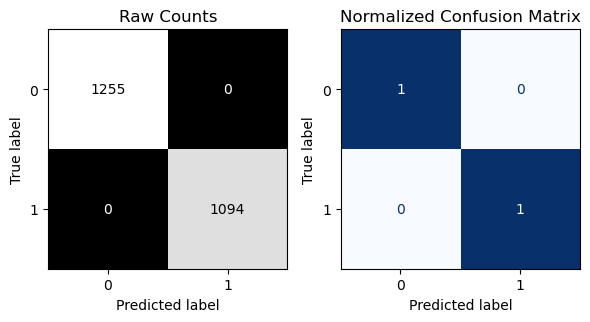


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       412
           1       0.92      0.88      0.90       371

    accuracy                           0.90       783
   macro avg       0.91      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



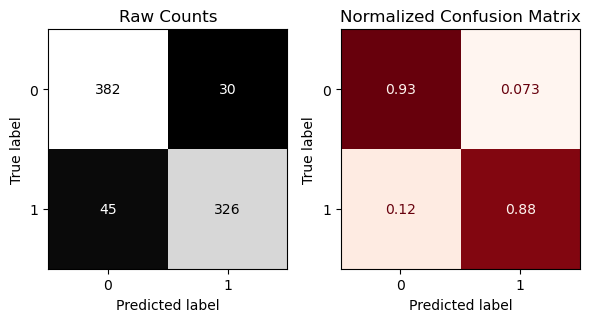

CPU times: total: 344 ms
Wall time: 432 ms


In [7]:
%%time
## Evaluate the intial model
evaluate_classification(rf_base, X_train_proc, y_train, X_test_proc, y_test)

# Select Based on: Correlation to Target

In this section we will select features based on the correlation of each feature to the target.

1. We will join the training features and target.  We will use only training data to avoid peeking at the test data.
2. We will determine the correlations between each feature and the target
3. We will select only the features whose correlation exceeds a chosen threshold
4. We will fit a new model on only the features with higher correlation to the target and evaluate it.

In [8]:
# Join the features and target
joined_data = pd.concat([X_train_proc, y_train], axis=1)
joined_data.head()

,sex,age,famsize,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,guardian_mother,guardian_other,Semester_G1,Semester_G2,Semester_G3,school/subject_GP mat,school/subject_GP por,school/subject_MS mat,school/subject_MS por,passed_exam
15,1.124806,0.207684,0.649548,0.342690,0.559335,-0.708012,0.043020,-0.401268,-0.349732,-1.245186,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
48,1.124806,1.823078,0.649548,-0.538030,-1.252911,-0.708012,-1.145854,-0.401268,-0.349732,-1.245186,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
259,1.124806,1.015381,-1.539532,-1.418750,-1.252911,0.651857,-1.145854,-0.401268,-0.349732,-1.245186,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
28,-0.889042,-1.407710,-1.539532,1.223409,-0.346788,-0.708012,0.043020,-0.401268,-0.349732,0.803093,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
41,-0.889042,0.207684,0.649548,0.342690,-0.346788,-0.708012,0.043020,-0.401268,-0.349732,-1.245186,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


We want both strong positive and negatively correlated features, we we will examine the absolute values of them.

In [9]:
## Calculate and the correlations and examine the correlations to the target
corrs = joined_data.corr()

## Examine the absolute values of the correlations to determine a threshold
feature_target_corrs = corrs['passed_exam'].abs().sort_values()
feature_target_corrs

guardian_mother          0.000743
famsup                   0.005354
Semester_G1              0.010186
Pstatus_T                0.014873
Pstatus_A                0.014873
reason_home              0.015117
paid                     0.021104
Fjob_other               0.021616
Mjob_other               0.030266
sex                      0.032590
Fjob_at_home             0.033646
Semester_G2              0.037120
famsize                  0.038086
romantic                 0.038877
Fjob_services            0.040405
Mjob_services            0.041813
famrel                   0.041857
Semester_G3              0.047698
guardian_father          0.048064
school/subject_GP mat    0.048181
health                   0.051818
freetime                 0.053472
Fjob_health              0.054002
reason_other             0.057343
school/subject_MS mat    0.059110
nursery                  0.065154
guardian_other           0.078974
Mjob_teacher             0.079984
activities               0.081399
schoolsup     

How many features do we want to keep?  The lowest 8 features all have correlations below .03.  We could try that as a threshold.  

In [10]:
## Set a correlation threshold
threshold = .03

## Create a filter using that threshold
correlated_features = feature_target_corrs > threshold

## Use the filter to subset the features
X_train_corr = X_train_proc.loc[:, correlated_features]
X_test_corr = X_test_proc.loc[:, correlated_features]

## Examine the results
print(X_train_corr.shape)
X_train_corr.columns

(2349, 43)


Index(['sex', 'age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'address_R', 'address_U', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_other', 'Semester_G2', 'Semester_G3', 'school/subject_GP mat',
       'school/subject_GP por', 'school/subject_MS mat',
       'school/subject_MS por'],
      dtype='object')

## Fit a new model just on the more highly correlated features

In [11]:
## Create and fit a model on the higher correlated features
rf_corrs = RandomForestClassifier(random_state=42)
rf_corrs.fit(X_train_corr, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



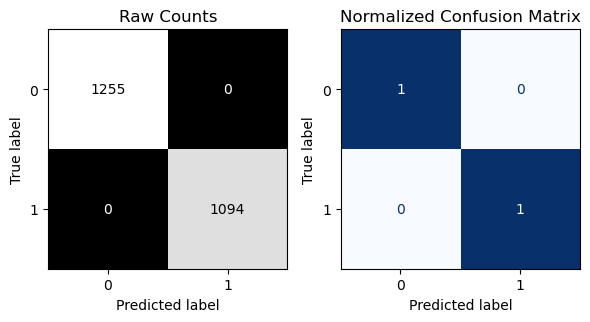


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       412
           1       0.92      0.83      0.88       371

    accuracy                           0.89       783
   macro avg       0.89      0.88      0.89       783
weighted avg       0.89      0.89      0.89       783



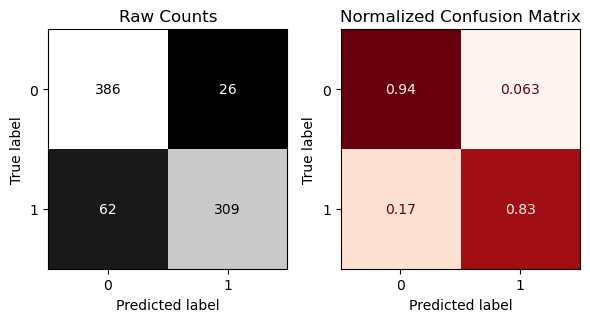

CPU times: total: 359 ms
Wall time: 395 ms


In [12]:
%%time
## Evaluate the correlation model

evaluate_classification(rf_corrs, X_train_corr, y_train, X_test_corr, y_test)

In [13]:
print(f'We reduced the number of features by {X_train_proc.shape[1] - X_train_corr.shape[1]}')

We reduced the number of features by 8


# Select based on: Permutation Importance

<font color='red'> You will need to do this on Project 4 Part 1 </font>

In this section we will:
1. Create and fit an initial model
2. Determine feature importances using `permutation_importance()`
3. Create a Series using the discovered importances
4. Create a filter out of the Series using a chosen threshold
5. Use that filter to select which features to keep.
6. Fit a new model using the selected features.

In [14]:
## Calculate feature importances
importances = permutation_importance(rf_base, X_train_proc, y_train)

## Create a Series of Feature Importances
importances_df = pd.Series(importances['importances_mean'], index=rf_base.feature_names_in_)
importances_df.sort_values(ascending=False)

school/subject_GP por    0.065390
failures                 0.060877
Semester_G1              0.024606
Semester_G3              0.018646
higher                   0.014049
absences                 0.013282
Semester_G2              0.011920
Medu                     0.005364
school/subject_GP mat    0.003065
Walc                     0.002469
Fedu                     0.002214
schoolsup                0.002129
Dalc                     0.002129
Mjob_at_home             0.002043
health                   0.001958
school/subject_MS por    0.001873
age                      0.001788
internet                 0.001447
studytime                0.001447
freetime                 0.001362
traveltime               0.001277
school/subject_MS mat    0.001192
goout                    0.001192
reason_reputation        0.001107
activities               0.000937
reason_home              0.000851
famsup                   0.000851
famrel                   0.000851
romantic                 0.000766
sex           

<Axes: >

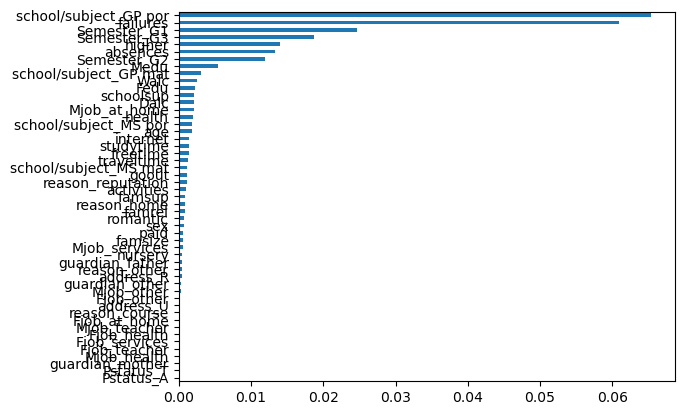

In [15]:
## Plot the importances
importances_df.sort_values().plot(kind='barh')

In [16]:
## Create a filter based on a threshold
threshold = 0
important_features = importances_df > threshold

## Use the filter to select features to keep
X_train_perm_sel = X_train_proc.loc[:,important_features]
X_test_perm_sel = X_test_proc.loc[:, important_features]
print(X_train_perm_sel.shape)
X_train_perm_sel.columns

(2349, 42)


Index(['sex', 'age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'address_R', 'address_U', 'Mjob_at_home',
       'Mjob_other', 'Mjob_services', 'Fjob_other', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_other', 'Semester_G1', 'Semester_G2', 'Semester_G3',
       'school/subject_GP mat', 'school/subject_GP por',
       'school/subject_MS mat', 'school/subject_MS por'],
      dtype='object')

## Fit a new model just on the more important features.

In [17]:
rf_perm_sel = RandomForestClassifier(random_state=42)
rf_perm_sel.fit(X_train_perm_sel, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



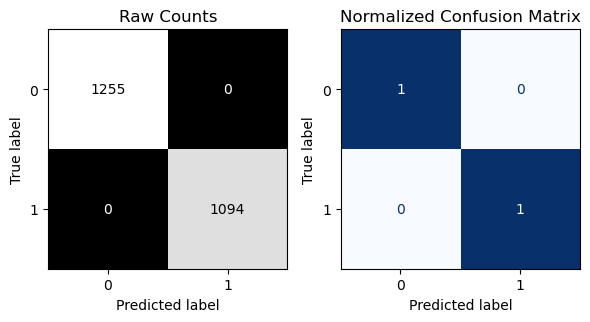


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       412
           1       0.92      0.87      0.90       371

    accuracy                           0.91       783
   macro avg       0.91      0.90      0.90       783
weighted avg       0.91      0.91      0.91       783



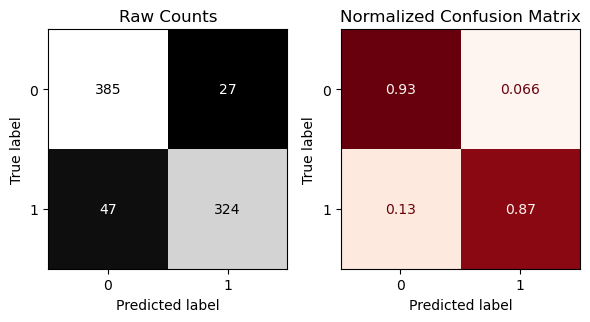

CPU times: total: 344 ms
Wall time: 396 ms


In [18]:
%%time
##Evaluate the model using permutation importance selected data
evaluate_classification(rf_perm_sel, X_train_perm_sel, y_train, X_test_perm_sel, y_test)

In [19]:
print(f'We reduced the number of features by {X_train_proc.shape[1] - X_train_perm_sel.shape[1]}')

We reduced the number of features by 9


# Select Based On: `SequentialFeatureSelection` wrapper class

In this section we will use a class that will fit many models with many combinations of features and see which combination is best.  This is simple to code, but can take a very long time!

1. Instantiate and fit the SequentialFeatureSelector class.  We will use the base RandomForestClassifier we made earlier for this.
2. Extract the features that the class suggests that we keep and use them to filter our data
3. Fit and evaluate a new model on just those features.

In [20]:
## Decide on a number of features to keep
num_features = 40

## Instantiate the feature selector
feat_selector = SequentialFeatureSelector(rf_base, n_features_to_select=num_features,
                                          direction='forward', cv=2,
                                          n_jobs=-1)

## Fit the feature selector
feat_selector.fit(X_train_proc, y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=40, n_jobs=-1)

In [21]:
## Extract the features suggested by the selector
features_to_keep = feat_selector.support_

## Use the filter to subset the features.
X_train_sel = X_train_proc.loc[:, features_to_keep]
X_test_sel = X_test_proc.loc[:, features_to_keep]

In [22]:
## Instanciate and fit a new model on just the features suggested by the selector
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_sel, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



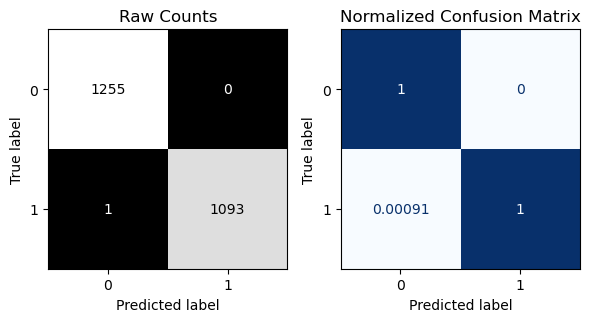


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       412
           1       0.92      0.87      0.89       371

    accuracy                           0.90       783
   macro avg       0.90      0.90      0.90       783
weighted avg       0.90      0.90      0.90       783



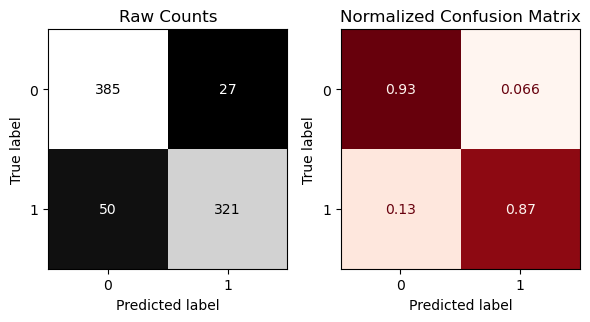

CPU times: total: 281 ms
Wall time: 399 ms


In [23]:
%%time
## Evaluate the model
evaluate_classification(rf_selected, X_train_sel, y_train, X_test_sel, y_test)

In [24]:
print(f'We reduced the dimensionality of the feature set by {X_train_proc.shape[1] - X_train_sel.shape[1]}')

We reduced the dimensionality of the feature set by 11


# Summary

In this notebook we implemented 3 methods for selecting features:

1. Selecting based on correlation of features to target
2. Selecting based on the permutation importance of each feature
3. Selecting based on the suggestions of an Scikit-Learn wrapper class.

In all cases we were able to reduce the number of features without significantly hurting the model metrics.

# Bonus:  SelectFromModel in a Pipeline

Since SelectFromModel has a .transform() method, it can be used in a pipeline!

In [25]:
## instantiate the selector with a model.
selector = SelectFromModel(rf_base)

## Put it in a pipeline between a preprocessor and another model
sel_pipe = make_pipeline(preprocessor, 
                         selector, 
                         RandomForestClassifier(random_state=42))

## Fit the pipeline
sel_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                                  Index(['sex', 'age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences'],
      dtype='object')),
                                                 ('Nominal',
                                                  O...Encoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'Semester',
       'school/subject'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1094

    accuracy                           1.00      2349
   macro avg       1.00      1.00      1.00      2349
weighted avg       1.00      1.00      1.00      2349



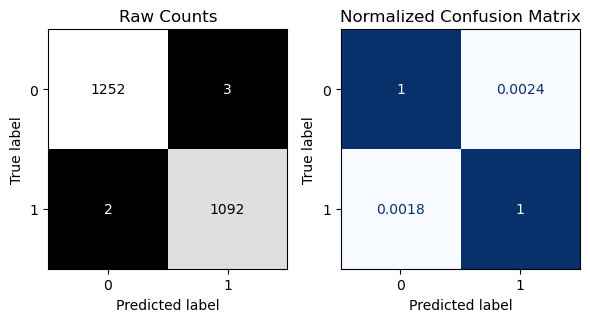


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       412
           1       0.88      0.85      0.86       371

    accuracy                           0.87       783
   macro avg       0.87      0.87      0.87       783
weighted avg       0.87      0.87      0.87       783



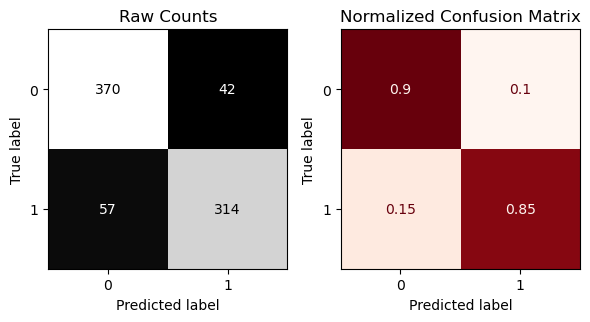

In [26]:
## Evaluate the pipeline model
evaluate_classification(sel_pipe, X_train, y_train, X_test, y_test)